In [36]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

import warnings, traceback

from IndexUtils import * 
from TileUtils import *
from featurematching import *
from ReadDate import *
from concurrent.futures import ThreadPoolExecutor

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist
import easyocr
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass

from sklearn.cluster import DBSCAN

from skimage.morphology import skeletonize

from scipy.interpolate import Rbf


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def processHalfSize(tiles, half_path):
    processing_images=[]
    for tile in tqdm(tiles):
        half_out_fn = os.path.join(half_path, os.path.basename(tile))
        processing_images.append(half_out_fn)
        if not os.path.exists(half_out_fn):
            a    = cv2.imread(tile)
            half = cv2.resize(a,  (0, 0), fx=0.5, fy=0.5)
            cv2.imwrite(half_out_fn, half)

def processSAHIresults(yolo_path, streetcorner_out_fn):
    def get_largest_subdirectory(base_dir):
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
        largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
        return os.path.join(base_dir, largest_subdir)

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")

    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )

    return streetcorner_dict
    

def processTiledYOLOs(tiles, model_paths, out_dict_names, proc_dir, imsizes):

    print("Making images half size for tiled inference")
    half_path = os.path.join(proc_dir, "half_size")
    os.makedirs(half_path, exist_ok=True)
    processHalfSize(tiles, half_path)
    
    out_dicts = []

    for i, model_path in enumerate(model_paths): 

        yolo_path = os.path.join(proc_dir, out_dict_names[i])
        os.makedirs(yolo_path, exist_ok=True)

        out_fn = os.path.join(proc_dir, f"{out_dict_names[i]}.pkl")
        
        if not os.path.exists(out_fn):
            
            detection_model = AutoDetectionModel.from_pretrained(
                model_type="yolov8",
                model_path=model_path,
                confidence_threshold=0.001,
                device="cuda",  # or 'cuda:0'
            )
            
            result = predict(source=half_path,
                            detection_model=detection_model, 
                            verbose=0, 
                            project=yolo_path,
                            slice_height=imsizes[i], 
                            slice_width=imsizes[i], 
                            model_device="cuda", 
                            return_dict=True, 
                            export_pickle=True,
                            visual_hide_labels=True)
            
            curr_dict = processSAHIresults(yolo_path, out_fn)
        else:
            print(f"Reading from {out_fn}")
            curr_dict = pickle.load(open(out_fn, "rb"))

        out_dicts.append(curr_dict)
    
    return out_dicts


In [39]:
base_input_path = r"D:\RECTDNN\uncompress\\"
# LIST ALL IMAGES IN DIRECTORY
image_files = []
wildcards = ['480287', '48201', '480296']

# wildcards = ['480296']
for w in wildcards:
    # print(f"Potential detections {w}: {len([a for a in list(tile_coords.keys()) if w in a])}")
    # print([a for a in list(tile_coords.keys()) if w in a])
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

In [ ]:
# model_paths = [
#     r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CCNN\CCNN_medium.pt",
#     r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
# ]
model_paths = [
    r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt"
]

proc_dir = r"D:\RECTDNN\processing\newtest\\"

out = processTiledYOLOs(tiles, model_paths, ['CornerCoordinates',], proc_dir, imsizes=[320])
# Performing inference on images:  73%|███████▎  | 625/859 [54:31<20:24,  5.23s/it]

Making images half size for tiled inference


  0%|          | 0/859 [00:00<?, ?it/s]

Performing inference on images:  73%|███████▎  | 625/859 [54:31<20:24,  5.23s/it]  


KeyboardInterrupt: 

In [9]:
model = TPNN(num_classes=3, finalpadding=1, inputsize=2)
checkpoint = torch.load(r'C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\FLNN/checkpoint_021524.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')

In [20]:
image = cv2.imread(r"D:\RECTDNN\processing\newtest\half_size\480296A_7.tif")
image = np.asarray(image)

In [24]:
test, _    = split_and_run_cnn(image, model, tilesize=2048, num_dim=3, edges=1, dims_rep=[0], n_pyramids=2, device="cuda", verbose=True)


# test = pickle.load(open(r"D:\RECTDNN\processing\newtest\CornerCoordinates.pkl", "rb"))

  0%|          | 0/1 [00:00<?, ?it/s]

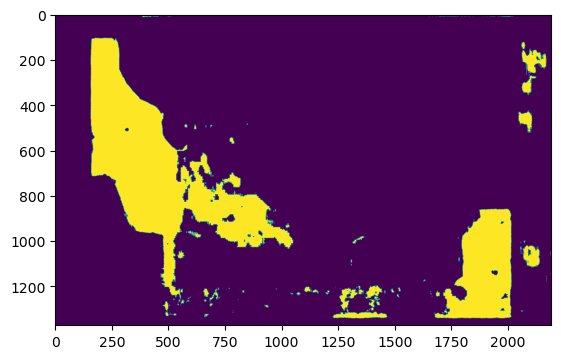

In [35]:
plt.imshow(test[:, :, 1]>0.5)